In [1]:
# 1. Create a massive list of possible activation functions
# 2. Iteratively create a graph for the target network using random activations and connectivity
# 3. See how well neural networks of different sizes and activation functions can solve it
#    Here I'm really just looking for diversity in the solutions.
# 4. Then try the same thing, but connect all hidden units to the output.
# 5. Try the same thing, but use all of the hidden units generated by all units.

In [49]:
import random
import time
from typing import Any, Dict, List, Type, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F

from phd.feature_search.core.idbd import IDBD
from phd.feature_search.core.models.base import LTU, FTA
from phd.feature_search.core.experiment_helpers import StandardizationStats, standardize_targets

In [3]:
class SinActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(x)
    
class NormActivation(nn.Module):
    def __init__(self, decay_rate: float = 0.99):
        super().__init__()
        self.stats = StandardizationStats(gamma=decay_rate)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, self.stats = standardize_targets(x, self.stats)
        return out

In [37]:
activation_functions = {
    'relu': nn.ReLU,
    'sigmoid': nn.Sigmoid,
    'tanh': nn.Tanh,
    'elu': nn.ELU,
    'leaky_relu': nn.LeakyReLU,
    'swish': nn.SiLU,
    'gelu': nn.GELU,
    'selu': nn.SELU,
    'softplus': nn.Softplus,
    'softsign': nn.Softsign,
    'linear': nn.Identity,
    'ltu': LTU,
    'fta': FTA,
    'sin': SinActivation,
    'norm': NormActivation,
}

In [38]:
input_dim = 20
n_hidden_activations = 20

In [39]:
class RandomNetwork():
    def __init__(
        self,
        input_dim: int,
        n_hidden_activations: int,
        activation_functions: Dict[str, Type[nn.Module]],
    ):
        self.input_dim = input_dim
        self.n_hidden_activations = n_hidden_activations
        self.activation_functions = activation_functions
        self.activations, self.node_input_ids = generate_random_network(
            input_dim, n_hidden_activations, activation_functions
        )
    
    def __call__(self, inputs: torch.Tensor) -> torch.Tensor:
        return compute_target_output(inputs, self.activations, self.node_input_ids)


def generate_random_network(
    input_dim: int,
    n_hidden_activations: int,
    activation_functions: Dict[str, Type[nn.Module]],
) -> Tuple[List[nn.Module], List[List[int]]]:
    """Generates a random network structure with specified input dimension and number of hidden activations.
    
    Args:
        input_dim: Number of input dimensions
        n_hidden_activations: Number of hidden activation nodes to generate
        activation_functions: Dictionary mapping activation names to activation classes
        
    Returns:
        Tuple containing:
            - List of activation modules
            - List of input indices for each activation node
    """
    n_hidden_units = input_dim
    max_connections_per_node = input_dim // 2
    activations = []
    node_input_ids = []
    
    for i in range(n_hidden_activations):
        activation_type = random.choice(list(activation_functions.keys()))
        n_inputs = random.randint(1, input_dim)
        if activation_type == 'fta':
            activations.append(FTA(1))
            n_outputs = 20
        else:
            activations.append(activation_functions[activation_type]())
            n_outputs = 1
        
        n_connections = random.randint(1, max_connections_per_node)
        input_ids = random.sample(range(n_hidden_units), n_connections)
        node_input_ids.append(input_ids)
        n_hidden_units += n_outputs
        
    return activations, node_input_ids


def compute_target_output(
    inputs: torch.Tensor, 
    activations: List[nn.Module], 
    node_input_ids: List[List[int]],
) -> torch.Tensor:
    all_values = inputs.clone()
    for i, activation in enumerate(activations):
        values = all_values[:, node_input_ids[i]]
        preactivation = values.sum(dim=1, keepdim=True)
        postactivation = activation(preactivation)
        all_values = torch.cat([all_values, postactivation], dim=1)
    return all_values

In [40]:
def create_mlp(
    layer_sizes: List[int],
    activation_class: Type[nn.Module],
    bias: bool = True,
) -> nn.Sequential:
    """Create a Multi-Layer Perceptron (MLP) with specified architecture.
    
    Args:
        layer_sizes: List of integers representing the size of each layer,
            including input and output layers. For example, [784, 128, 64, 10]
            creates a network with input size 784, two hidden layers of 128 and 64
            neurons, and output size 10.
        activation_class: PyTorch activation function class (e.g., nn.ReLU,
            nn.Tanh, nn.Sigmoid, nn.LeakyReLU).
        dropout_rate: Optional dropout rate to apply between layers. If None,
            no dropout is applied.
        batch_norm: Whether to apply batch normalization between layers.
        bias: Whether to include bias terms in linear layers.
    
    Returns:
        nn.Sequential: A PyTorch Sequential model representing the MLP.
    
    Raises:
        ValueError: If layer_sizes has fewer than 2 elements (input and output).
        ValueError: If any layer size is not positive.
    """
    if len(layer_sizes) < 2:
        raise ValueError(
            "layer_sizes must contain at least 2 elements (input and output)"
        )
    
    if any(size <= 0 for size in layer_sizes):
        raise ValueError("All layer sizes must be positive integers")
    
    layers = []
    
    for i in range(len(layer_sizes) - 1):
        # Add linear layer
        layers.append(
            nn.Linear(
                in_features = layer_sizes[i],
                out_features = layer_sizes[i + 1],
                bias = bias and i < len(layer_sizes) - 2,
            )
        )
        
        # Add activation function (except for the last layer)
        if i < len(layer_sizes) - 2:
            layers.append(activation_class())
    
    return nn.Sequential(*layers)

In [43]:
def train_model(model: nn.Module, train_inputs: torch.Tensor, train_outputs: torch.Tensor,
                test_inputs: torch.Tensor, test_outputs: torch.Tensor, 
                n_epochs: int, repr_step_size: float, batch_size: int) -> Tuple[List[float], List[float]]:
    """Train a model and return training and test losses."""
    # output_optimizer = IDBD(
    #     params = model[-1].parameters(),
    #     meta_lr = 0.005,
    #     init_lr = 0.01,
    #     version = 'squared_grads',
    #     autostep = True,
    # )
    # if len(model) > 1:
    repr_optimizer = optim.Adam(model.parameters(), lr=repr_step_size)
    # else:
    #     repr_optimizer = None
    
    train_losses = []
    test_losses = []
    
    n_train_batches = len(train_inputs) // batch_size
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx in range(n_train_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            
            batch_inputs = train_inputs[start_idx:end_idx]
            batch_outputs = train_outputs[start_idx:end_idx]
            
            outputs = model(batch_inputs)
            loss = F.mse_loss(outputs, batch_outputs)
            
            # Backward pass
            # output_optimizer.zero_grad()
            if repr_optimizer is not None:
                repr_optimizer.zero_grad()
            
            loss.backward() # retain_graph=True)
            
            # output_optimizer.step(outputs)
            if repr_optimizer is not None:
                repr_optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= n_train_batches
        train_losses.append(train_loss)
        
        # Evaluation phase
        model.eval()
        with torch.no_grad():
            test_outputs_pred = model(test_inputs)
            test_loss = F.mse_loss(test_outputs_pred, test_outputs).item()
        
        test_losses.append(test_loss)
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}")
    
    return train_losses, test_losses

In [53]:
n_epochs = 200
batch_size = train_inputs.shape[0]
# activation_class = nn.SiLU  # Using ReLU as the activation function

activation_classes = [nn.ReLU, nn.SiLU, nn.Tanh, nn.ELU, nn.GELU, nn.LeakyReLU, nn.SELU, nn.Sigmoid]
n_layers = 3
hidden_dim_values = [10, 200]

# Run experiments
results = {}
for activation_class in activation_classes:
    for hidden_dim in hidden_dim_values:
        print(f"\nTraining model with {activation_class.__name__} activation and {hidden_dim} hidden units...")
        
        # Create layer sizes
        layer_sizes = [input_dim] + [hidden_dim] * (n_layers - 1) + [train_outputs.shape[1]]
        
        # Create model
        model = create_mlp(layer_sizes, activation_class)
        learning_rate = 0.1 / hidden_dim ** 0.5
        
        # Train model
        train_losses, test_losses = train_model(
            model, train_inputs, train_outputs, test_inputs, test_outputs,
            n_epochs, learning_rate, batch_size
        )
        
        # Store results
        results[(activation_class.__name__, hidden_dim)] = {
            'train_losses': train_losses,
            'test_losses': test_losses
        }


Training model with ReLU activation and 10 hidden units...
Epoch 0: Train Loss = 0.083074, Test Loss = 0.030310
Epoch 20: Train Loss = 0.024598, Test Loss = 0.023520
Epoch 40: Train Loss = 0.024298, Test Loss = 0.023715
Epoch 60: Train Loss = 0.023987, Test Loss = 0.023807
Epoch 80: Train Loss = 0.023640, Test Loss = 0.023795
Epoch 100: Train Loss = 0.023137, Test Loss = 0.023823
Epoch 120: Train Loss = 0.022370, Test Loss = 0.023664
Epoch 140: Train Loss = 0.021219, Test Loss = 0.023346
Epoch 160: Train Loss = 0.020017, Test Loss = 0.023426
Epoch 180: Train Loss = 0.018954, Test Loss = 0.023759

Training model with ReLU activation and 200 hidden units...
Epoch 0: Train Loss = 0.033336, Test Loss = 1.946082
Epoch 20: Train Loss = 0.025519, Test Loss = 0.024265
Epoch 40: Train Loss = 0.025507, Test Loss = 0.024256
Epoch 60: Train Loss = 0.025507, Test Loss = 0.024257


KeyboardInterrupt: 

In [52]:
def plot_ablation_results(
    results_dict: Dict[Tuple[Any, Any], Dict[str, List[float]]],
    row_variable: str,
    col_variable: str,
    n_epochs: int,
    figsize: Tuple[int, int] = (15, 12)
):
    """Plot a grid of training curves comparing different model configurations.
    
    Args:
        results_dict: Dictionary mapping (row_val, col_val) tuples to results_dict containing
            'train_losses' and 'test_losses' lists
        row_variable: Name of the variable that varies across rows
        col_variable: Name of the variable that varies across columns 
        n_epochs: Number of training epochs
        figsize: Figure size (width, height) in inches
    """
    # Extract unique values for rows and columns
    row_values = sorted(list({r for r, _ in results_dict.keys()}))
    col_values = sorted(list({c for _, c in results_dict.keys()}))
    
    # Create figure and axes grid
    fig, axes = plt.subplots(
        len(row_values), len(col_values),
        figsize=figsize, sharex=True, sharey=True
    )
    
    # Ensure axes is always 2D
    if len(row_values) == 1:
        axes = axes.reshape(1, -1)
    if len(col_values) == 1:
        axes = axes.reshape(-1, 1)

    # Find global min and max for consistent axis limits
    all_train_losses = []
    all_test_losses = []
    for result in results_dict.values():
        all_train_losses.extend(result['train_losses'])
        all_test_losses.extend(result['test_losses'])

    y_min = min(min(all_train_losses), min(all_test_losses))
    y_max = max(max(all_train_losses), max(all_test_losses))

    # Add padding to y-axis, using multiplicative padding for log scale
    y_min = y_min / 1.5  # Divide by >1 to extend lower bound
    y_max = y_max * 1.1  # Multiply by >1 to extend upper bound

    epochs = list(range(1, n_epochs + 1))

    for i, row_val in enumerate(row_values):
        for j, col_val in enumerate(col_values):
            ax = axes[i, j]
            
            result = results_dict[(row_val, col_val)]
            train_losses = result['train_losses']
            test_losses = result['test_losses']
            
            ax.plot(epochs, train_losses, label='Train', color='blue', alpha=0.7)
            ax.plot(epochs, test_losses, label='Test', color='red', alpha=0.7)
            
            ax.set_title(f'{row_variable}={row_val}, {col_variable}={col_val}')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Set y-axis to log scale
            ax.set_yscale('log')
            
            # Set consistent axis limits
            ax.set_ylim(y_min, y_max)
            ax.set_xlim(1, n_epochs)

    plt.tight_layout()
    plt.show()

    # Print final results summary
    print("\nFinal Results Summary:")
    print("=" * 50)
    for row_val in row_values:
        for col_val in col_values:
            result = results_dict[(row_val, col_val)]
            final_train_loss = result['train_losses'][-1]
            final_test_loss = result['test_losses'][-1]
            print(f"{row_variable}={row_val}, {col_variable}={col_val}:")
            print(f"  Final Train Loss: {final_train_loss:.6f}")
            print(f"  Final Test Loss: {final_test_loss:.6f}")
            print()

In [58]:
# Create a random target network
target_network = RandomNetwork(
    input_dim, n_hidden_activations, activation_functions)

n_train_samples = 10_000
n_test_samples = 1000
n_total_samples = n_train_samples + n_test_samples

inputs = torch.randn(n_total_samples, input_dim)
outputs = target_network(inputs)[:, -1:]

train_inputs = inputs[:n_train_samples]
train_outputs = outputs[:n_train_samples]

test_inputs = inputs[n_train_samples:]
test_outputs = outputs[n_train_samples:]

In [61]:
target_network.activations

[LTU(),
 LTU(),
 GELU(approximate='none'),
 Tanh(),
 SinActivation(),
 Sigmoid(),
 Softsign(),
 Identity(),
 LeakyReLU(negative_slope=0.01),
 GELU(approximate='none'),
 SELU(),
 LTU(),
 Identity(),
 NormActivation(
   (stats): StandardizationStats()
 ),
 Softplus(beta=1.0, threshold=20.0),
 GELU(approximate='none'),
 GELU(approximate='none'),
 Softplus(beta=1.0, threshold=20.0),
 LeakyReLU(negative_slope=0.01),
 GELU(approximate='none')]

In [62]:
n_epochs = 200
batch_size = train_inputs.shape[0]
# activation_class = nn.SiLU  # Using ReLU as the activation function

activation_classes = [nn.Identity, nn.ReLU, nn.SiLU, nn.Tanh, nn.ELU, nn.GELU, nn.LeakyReLU, nn.SELU, nn.Sigmoid]
n_layers = 3
hidden_dim_values = [10, 200]

# Run experiments
results = {}
for activation_class in activation_classes:
    for hidden_dim in hidden_dim_values:
        print(f"\nTraining model with {activation_class.__name__} activation and {hidden_dim} hidden units...")
        
        # Create layer sizes
        layer_sizes = [input_dim] + [hidden_dim] * (n_layers - 1) + [train_outputs.shape[1]]
        
        # Create model
        model = create_mlp(layer_sizes, activation_class)
        learning_rate = 0.1 / hidden_dim ** 0.5
        
        # Train model
        train_losses, test_losses = train_model(
            model, train_inputs, train_outputs, test_inputs, test_outputs,
            n_epochs, learning_rate, batch_size
        )
        
        # Store results
        results[(activation_class.__name__, hidden_dim)] = {
            'train_losses': train_losses,
            'test_losses': test_losses
        }


Training model with Identity activation and 10 hidden units...
Epoch 0: Train Loss = 248.470444, Test Loss = 238.791656
Epoch 20: Train Loss = 26.762884, Test Loss = 29.788309
Epoch 40: Train Loss = 16.311176, Test Loss = 16.284958
Epoch 60: Train Loss = 15.096729, Test Loss = 15.911865
Epoch 80: Train Loss = 14.960111, Test Loss = 15.528633
Epoch 100: Train Loss = 14.942256, Test Loss = 15.569114
Epoch 120: Train Loss = 14.938452, Test Loss = 15.559056
Epoch 140: Train Loss = 14.938396, Test Loss = 15.556948
Epoch 160: Train Loss = 14.938344, Test Loss = 15.559830
Epoch 180: Train Loss = 14.938340, Test Loss = 15.559518

Training model with Identity activation and 200 hidden units...
Epoch 0: Train Loss = 245.156357, Test Loss = 206.581100
Epoch 20: Train Loss = 22.107779, Test Loss = 21.666727
Epoch 40: Train Loss = 15.833801, Test Loss = 16.324808
Epoch 60: Train Loss = 15.042526, Test Loss = 15.722878
Epoch 80: Train Loss = 14.955423, Test Loss = 15.622852
Epoch 100: Train Loss = 

KeyboardInterrupt: 

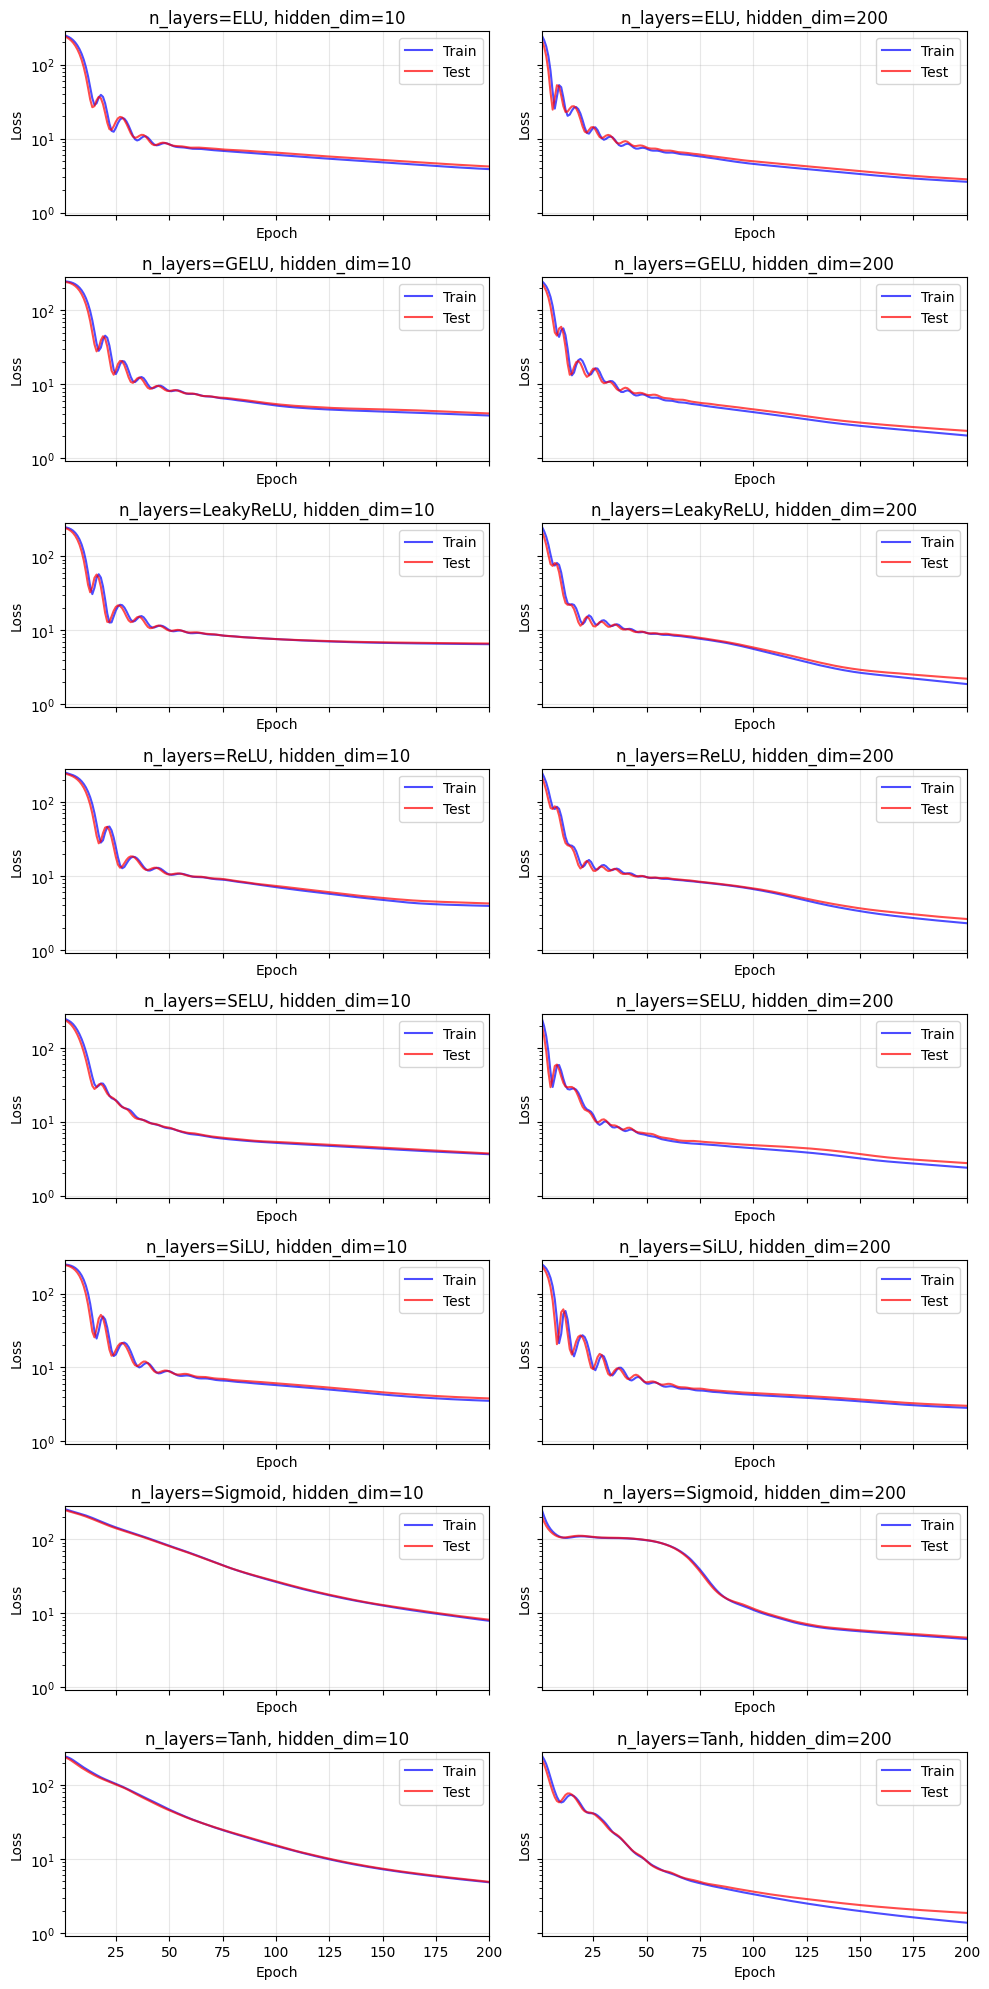


Final Results Summary:
n_layers=ELU, hidden_dim=10:
  Final Train Loss: 3.863631
  Final Test Loss: 4.193252

n_layers=ELU, hidden_dim=200:
  Final Train Loss: 2.604713
  Final Test Loss: 2.813861

n_layers=GELU, hidden_dim=10:
  Final Train Loss: 3.789374
  Final Test Loss: 4.043210

n_layers=GELU, hidden_dim=200:
  Final Train Loss: 2.032485
  Final Test Loss: 2.351307

n_layers=LeakyReLU, hidden_dim=10:
  Final Train Loss: 6.453188
  Final Test Loss: 6.591965

n_layers=LeakyReLU, hidden_dim=200:
  Final Train Loss: 1.865013
  Final Test Loss: 2.203418

n_layers=ReLU, hidden_dim=10:
  Final Train Loss: 3.930346
  Final Test Loss: 4.237695

n_layers=ReLU, hidden_dim=200:
  Final Train Loss: 2.290867
  Final Test Loss: 2.612911

n_layers=SELU, hidden_dim=10:
  Final Train Loss: 3.625489
  Final Test Loss: 3.714594

n_layers=SELU, hidden_dim=200:
  Final Train Loss: 2.384287
  Final Test Loss: 2.751064

n_layers=SiLU, hidden_dim=10:
  Final Train Loss: 3.535913
  Final Test Loss: 3.809

In [60]:
plot_ablation_results(results, 'n_layers', 'hidden_dim', n_epochs, figsize=(10, 20))

In [33]:
outputs.shape

torch.Size([1000, 40])

In [11]:
outputs.shape

torch.Size([1000, 59])

In [15]:
activations

[Identity(),
 SELU(),
 SinActivation(),
 Sigmoid(),
 SiLU(),
 GELU(approximate='none'),
 FTA(),
 Tanh(),
 Sigmoid(),
 ELU(alpha=1.0),
 Identity(),
 ReLU(),
 Identity(),
 NormActivation(
   (stats): StandardizationStats()
 ),
 SiLU(),
 Softsign(),
 ReLU(),
 Identity(),
 Tanh(),
 ReLU()]